# EXPLORATION OF DIMENSION REDUCTION TECHNIQUES

**Start date**: September 19, 2023

**Summary**: Our goal is to explore dimension reduction technqiues: features selection & extraction. These methods will eventually be tested on head & neck and lung cancer imaging data to determine the most effective combination for this application.

**Data**: The data used here is from a Kaggle Oropharynx Cancer Radiomics Challenge. The goal is to predict a binary variable of local recurrence.

# Setup

In [20]:
import pandas as pd

In [145]:
# read in data
test_data = pd.read_csv("Test.csv")
train_data = pd.read_csv("Training.csv")

### Clean train data:

In [38]:
# Local_tumor_recurrence is the binary col to predict
X_train = train_data.iloc[:, 2:]
y_train = train_data['Local_tumor_recurrence']

In [39]:
# remove all rows with NaN
X = X_train.dropna()
X = X.reset_index(drop=True)

# Get the corresponding y values
y = y_train[X.index]

In [130]:
from sklearn.preprocessing import LabelEncoder

# convert categorical to numerical
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

### Clean test data:

In [146]:
test_data = test_data.drop(test_data.columns[1], axis=1)
X_test = test_data.dropna()
X_test = X_test.reset_index(drop=True)

for column in X_test.select_dtypes(include=['object']).columns:
    X_test[column] = label_encoder.fit_transform(X_test[column])

TO DO: test all these methods on the test data, then combo methods

# Feature Selection

## Filter methods:

### Information Gain

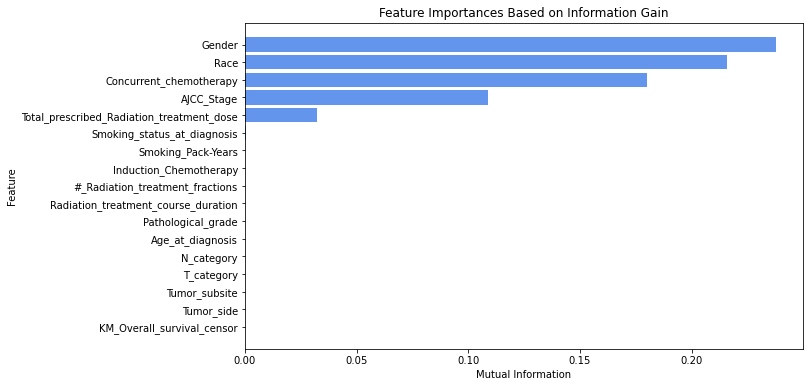

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_new = selector.fit_transform(X, y)
mutual_information_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': mutual_information_scores})
feature_scores_df = feature_scores_df.sort_values(by='Information Gain', ascending=False)

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Information Gain'], color='cornflowerblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Feature Importances Based on Information Gain')
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()

### Chi-square Test

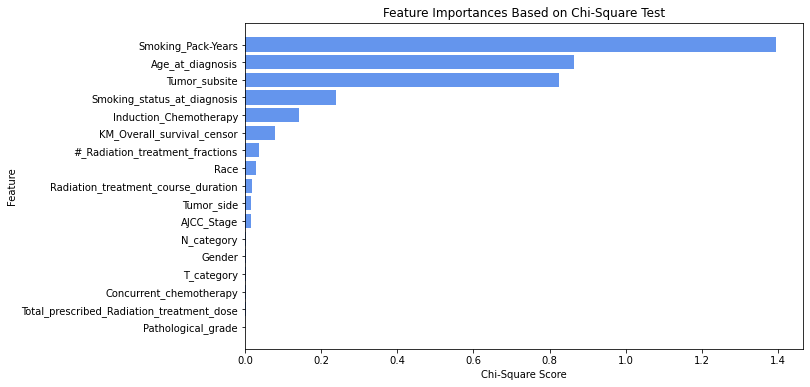

In [73]:
from sklearn.feature_selection import chi2

selector = SelectKBest(score_func=chi2, k='all')
X_new = selector.fit_transform(X, y)
chi_square_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Chi_Square_Score': chi_square_scores})
feature_scores_df = feature_scores_df.sort_values(by='Chi_Square_Score', ascending=False)

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Chi_Square_Score'], color='cornflowerblue')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.title('Feature Importances Based on Chi-Square Test')
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()

### Fisher's Score

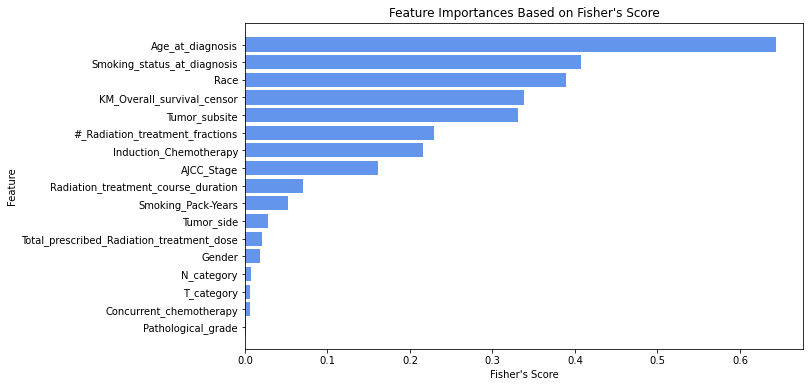

In [72]:
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)
fishers_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Fisher_Score': fishers_scores})
feature_scores_df = feature_scores_df.sort_values(by='Fisher_Score', ascending=False)

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Fisher_Score'], color='cornflowerblue')
plt.xlabel("Fisher's Score")
plt.ylabel('Feature')
plt.title("Feature Importances Based on Fisher's Score")
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()

### Correlation Coefficient

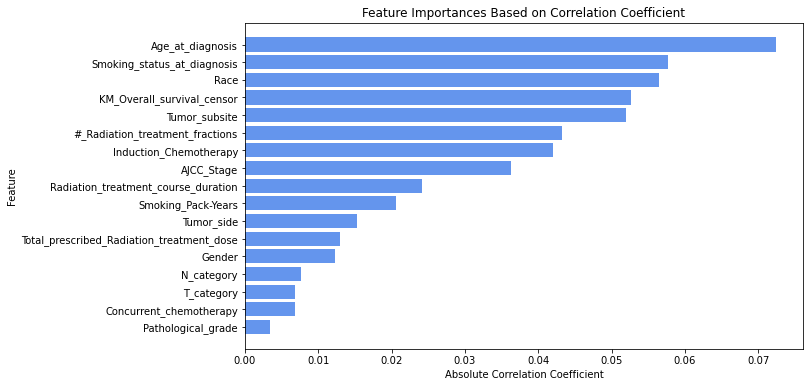

In [71]:
import numpy as np 

correlation_coefficients = X.apply(lambda col: col.corr(y))
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Correlation_Coefficient': correlation_coefficients})
feature_scores_df['Correlation_Coefficient'] = np.abs(feature_scores_df['Correlation_Coefficient'])
feature_scores_df = feature_scores_df.sort_values(by='Correlation_Coefficient', ascending=False)

# plot the importances of each feature
plt.figure(figsize=(10, 6))
plt.barh(feature_scores_df['Feature'], feature_scores_df['Correlation_Coefficient'], color='cornflowerblue')
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importances Based on Correlation Coefficient')
plt.gca().invert_yaxis()  # show the most important features at the top
plt.show()

## Wrapper methods:

### Forward Feature Selection

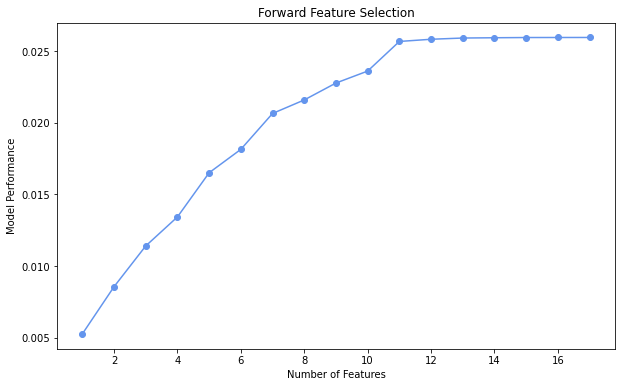

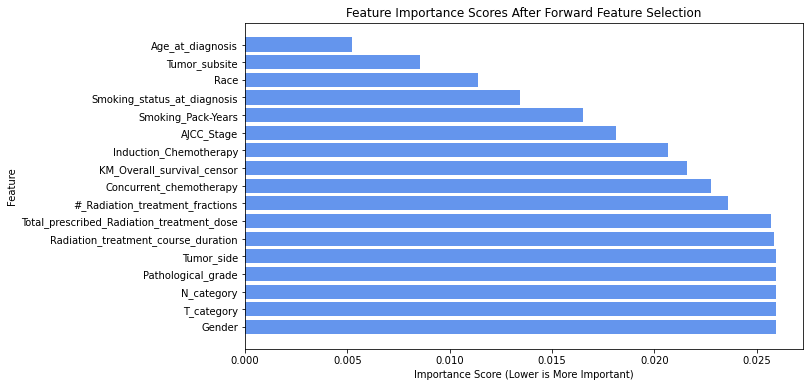

In [96]:
from sklearn.linear_model import LinearRegression # can be smtg else

selected_features = []
model_performance = []

def evaluate_model(features):
    model = LinearRegression()
    model.fit(X[features], y)
    return model.score(X[features], y)

feature_importance_dict = {}

while len(selected_features) < len(X.columns):
    best_feature = None
    best_performance = -np.inf
    
    # Iterate over remaining features and select the one that improves the model the most
    for feature in X.columns:
        if feature not in selected_features:
            features_to_try = selected_features + [feature]
            performance = evaluate_model(features_to_try)
            if performance > best_performance:
                best_feature = feature
                best_performance = performance
    
    if best_feature is not None:
        selected_features.append(best_feature)
        model_performance.append(best_performance)
        feature_importance_dict[best_feature] = best_performance

# plot performance improvement with each added feature
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selected_features) + 1), model_performance, marker='o', color='cornflowerblue')
plt.xlabel('Number of Features')
plt.ylabel('Model Performance')
plt.title('Forward Feature Selection')
plt.show()

# plateaus at 11 features

# plot the importances of each feature ?? 
plt.figure(figsize=(10, 6))
plt.barh(list(feature_importance_dict.keys()), list(feature_importance_dict.values()), color='cornflowerblue')
plt.xlabel('Importance Score (Lower is More Important)')
plt.ylabel('Feature')
plt.title('Feature Importance Scores After Forward Feature Selection')
plt.gca().invert_yaxis()
plt.show()

### Recursive Feature Elimination

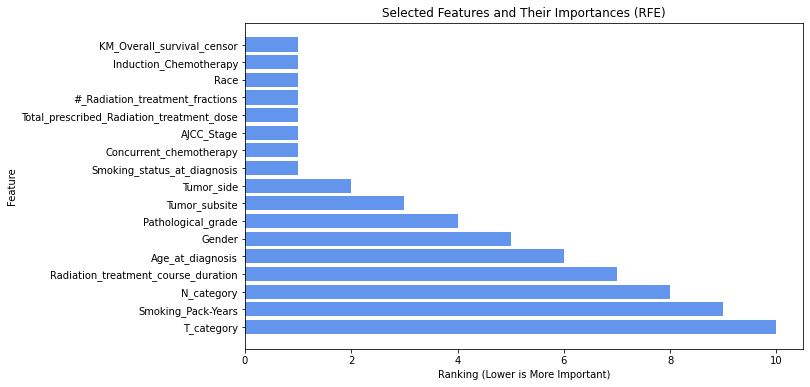

In [95]:
from sklearn.feature_selection import RFE

estimator = LinearRegression()
rfe = RFE(estimator)
num_features_to_select = 5  # ??
rfe.fit(X, y)
rfe.n_features_to_select = num_features_to_select  
selected_features_mask = rfe.support_
feature_ranking = rfe.ranking_
selected_features = X.columns[selected_features_mask].tolist()
feature_ranking_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_ranking})
feature_ranking_df = feature_ranking_df.sort_values(by='Ranking', ascending=True)

# plot the selected features and their rankings
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking_df['Feature'], feature_ranking_df['Ranking'], color='cornflowerblue')
plt.xlabel('Ranking (Lower is More Important)')
plt.ylabel('Feature')
plt.title('Selected Features and Their Importances (RFE)')
plt.gca().invert_yaxis()  # invert the y-axis to show the most important features at the top
plt.show()

## Embedded methods:

### LASSO

In [105]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)  # num folds?
lasso.fit(X, y)
coefficients = lasso.coef_
feature_coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# filter out features with coefficient values equal to zero
selected_features = feature_coefficients_df[feature_coefficients_df['Coefficient'] != 0]

# print the selected features and their coefficients
print("Selected features based on Lasso:")
print(selected_features)

Selected features based on Lasso:
            Feature  Coefficient
1  Age_at_diagnosis    -0.000558


### Random Forest

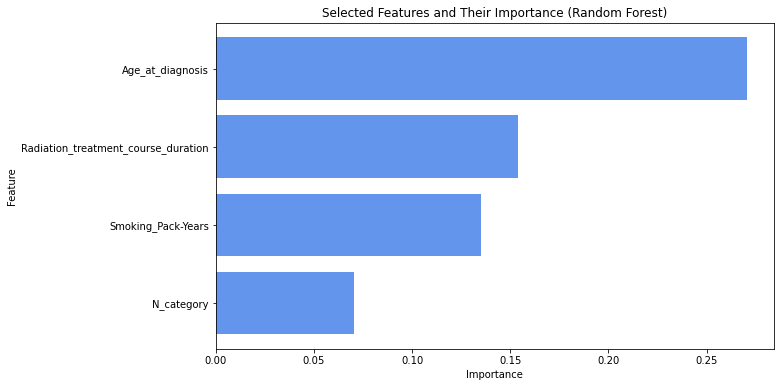

In [110]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of estimators
rf_model.fit(X, y)
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
importance_threshold = 0.05  # Change this threshold based on your preference

selected_features = feature_importances_df[feature_importances_df['Importance'] >= importance_threshold]

# plot the selected features and their importances
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], selected_features['Importance'], color='cornflowerblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Selected Features and Their Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()

# Feature Extraction

### PCA

Explained Variance Ratio of Each Component:
[0.82413659 0.12510607]


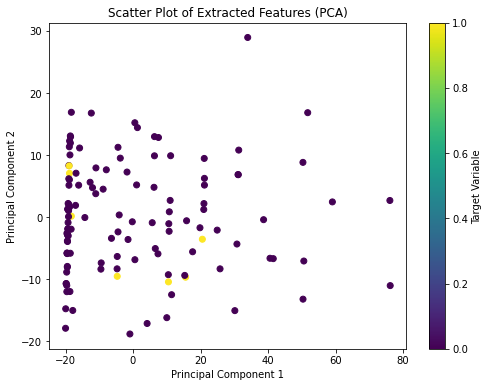

In [125]:
from sklearn.decomposition import PCA

n_components = 2  # 
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
                          
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio of Each Component:")
print(explained_variance_ratio)

# scatter plot of the extracted features
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Extracted Features (PCA)')
plt.colorbar(label='Target Variable')
plt.show()

In [123]:
pca.fit(X)
# loadings of each original feature on PC1
loadings = pca.components_[0]

feature_loadings_df = pd.DataFrame({'Feature': X.columns, 'Loading on PC1': loadings})
feature_loadings_df['Absolute Loading'] = abs(feature_loadings_df['Loading on PC1'])
feature_loadings_df = feature_loadings_df.sort_values(by='Absolute Loading', ascending=False)

# print the top contributing features to PC1
print("Top Contributing Features to PC1:")
print(feature_loadings_df)

Top Contributing Features to PC1:
                                      Feature  Loading on PC1  \
10                         Smoking_Pack-Years        0.998159   
1                            Age_at_diagnosis        0.046173   
11        Radiation_treatment_course_duration        0.023463   
9                 Smoking_status_at_diagnosis       -0.021503   
12  Total_prescribed_Radiation_treatment_dose        0.012672   
5                                  T_category        0.010589   
4                               Tumor_subsite        0.009352   
8                          Pathological_grade       -0.008480   
6                                  N_category        0.006158   
13            #_Radiation_treatment_fractions        0.004757   
15                    Concurrent_chemotherapy        0.004502   
16                 KM_Overall_survival_censor       -0.003000   
7                                  AJCC_Stage        0.002276   
2                                        Race        0.0

### LPP

### Wavelet

# Combinations

All of the exploration above were run independently. In literature, we have seen the value of hybrid models — merging feature selection & hybrid models. Here we will explore some potentially promising combinations as well as play around with our own.

### 1. Fisher, Information Gain --> PCA

In [ ]:
# testing has to be unsupervised, since we don't know the labels

In [149]:
from sklearn.preprocessing import StandardScaler

# Feature selection using Fisher's Score (SelectKBest)
k_best_fisher = SelectKBest(score_func=f_classif, k=5)  # You can adjust 'k' as needed
X_train_fisher = k_best_fisher.fit_transform(X, y)

# Feature selection using Information Gain (SelectKBest)
k_best_info_gain = SelectKBest(score_func=mutual_info_classif, k=5)  # You can adjust 'k' as needed
X_train_info_gain = k_best_info_gain.fit_transform(X, y)

# Standardize the selected features
scaler = StandardScaler()
X_train_fisher_scaled = scaler.fit_transform(X_train_fisher)
X_train_info_gain_scaled = scaler.fit_transform(X_train_info_gain)

# Feature extraction using PCA on Fisher-selected features
pca_fisher = PCA(n_components=5)  # You can adjust the number of components
X_train_pca_fisher = pca_fisher.fit_transform(X_train_fisher_scaled)

# Feature extraction using PCA on Info Gain-selected features
pca_info_gain = PCA(n_components=5)  # You can adjust the number of components
X_train_pca_info_gain = pca_info_gain.fit_transform(X_train_info_gain_scaled)

# Apply the same feature selection, scaling, and PCA transformations to the test data
X_test_fisher = k_best_fisher.transform(X_test)
X_test_info_gain = k_best_info_gain.transform(X_test)
X_test_fisher_scaled = scaler.transform(X_test_fisher)
X_test_info_gain_scaled = scaler.transform(X_test_info_gain)
X_test_pca_fisher = pca_fisher.transform(X_test_fisher_scaled)
X_test_pca_info_gain = pca_info_gain.transform(X_test_info_gain_scaled)

# Unsupervised learning model (K-Means clustering in this example)
kmeans_fisher = KMeans(n_clusters=3)  # You can choose the number of clusters
kmeans_info_gain = KMeans(n_clusters=3)  # You can choose the number of clusters

# Fit the unsupervised models to the transformed training data
kmeans_fisher.fit(X_train_pca_fisher)
kmeans_info_gain.fit(X_train_pca_info_gain)

# Predict clusters for the test data
labels_fisher = kmeans_fisher.predict(X_test_pca_fisher)
labels_info_gain = kmeans_info_gain.predict(X_test_pca_info_gain)

# The 'labels_fisher' and 'labels_info_gain' now contain cluster labels for the test data

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Patient_ID
- Smoking Pack-Years
Feature names seen at fit time, yet now missing:
- Smoking_Pack-Years
